# Base - Reaction-diffusion

- author: Marcelo de Gomensoro Malheiros
- revision: 2020-09
- license: MIT (attribution is not required but greatly appreciated)

## Turing model
- diffusion rates are based on the ratio $r$ and scale $s$
- depends on explicitly clipping lower values at $L_a$ and $L_b$
- depends on explicitly clipping higher values at $U_a$ and $U_b$

\begin{align}
\frac{\partial{a}}{\partial{t}} &= 16 - a b + r s \nabla^2 a
\\
\\
\frac{\partial{b}}{\partial{t}} &= a b - b - 12 + s \nabla^2 b
\end{align}

In [44]:
import numpy as np
from scipy import ndimage

def turing_model(ma, mb, ka, kb, la, lb, da, db, dt, ia, ib, sa, sb, wrap):

    if wrap:
        ndimage.convolve(ma, ka, output=la, mode='wrap')
        ndimage.convolve(mb, kb, output=lb, mode='wrap')
    else:
        ndimage.convolve(ma, ka, output=la, mode='reflect')
        ndimage.convolve(mb, kb, output=lb, mode='reflect')
        
    na = ma + (16 - ma * mb      + da * la) * dt
    nb = mb + (ma * mb - mb - 12 + db * lb) * dt

    global a, b
    np.clip(na, ia, sa, out=a)
    np.clip(nb, ib, sb, out=b)

## Simulation

Parameter list, with default values shown:
- `ratio=5` - ratio between A and B diffusion rates
- `scale=1` - overall scale of the pattern
- `speed=100` - percent of default time step
- `start=0` - start iteration counter
- `stop=1000` - final iteration counter
- `time=None` - simulation time (in milliseconds), used instead of `stop` and taking into account `speed`
- `use_a=False` - use previous values for A?
- `use_b=False` - use previous values for B?
- `wrap=True` - use toroidal domain if true, non-flux boundary otherwise
- `seed=1` - random seed
- `ini_a=4` - initial constant values for A
- `ini_b=4` - initial constant values for B
- `var_a=0` - added randomness magnitude for A
- `var_b=1` - added randomness magnitude for B
- `shape=40` - domain dimension (single integer for square, or tuple)
- `inf_a=0` - lower bound for A
- `inf_b=0` - lower bound for B
- `sup_a=1000` - upper bound for A
- `sup_b=1000` - upper bound for B
- `axis=False` - show domain size?
- `cmap='inferno'` - Matplotlib colormap used
- `first=False` - show initial state?
- `info=False` - monitor concentration intervals (each 100 iterations, may be changed)
- `limit=None` - plot images with given dimension
- `show='a'` - reagents to show (can be the empty string, either `a` or `b`, or both)
- `size=2` - image output size
- `snap=4` - how many captures are shown (can also be a list of iteration counts)
- `detail=None` - show 1-D plot at given domain row (A in orange and B in blue)
- `extent=(0, 10)` - upper and lower values for 1-D plot
- `func=None` - auxiliary function
- `out=None` - output file name (PDF/PNG/JPG/...)
- `dpi=100` - resolution for output
- `interpolation='bilinear'` - used when converting a matrix to an image
- `detect=False` - detect constant-valued and stable pattern states, besides numerical problems (each 100 iterations, may be changed)
- `model=turing_model` - model function used

Global variables set after the simulation is run:
- `a` - final concentrations for A
- `b` - final concentrations for B
- `sim` - information about the simulation (can be used as an object or a dict)

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# turing: bounded non-linear Turing reaction-diffusion model - v6.3

kernel_a = kernel_b = np.array([[1, 4, 1], [4, -20, 4], [1, 4, 1]]) / 6

class Bunch(dict):
    def __init__(self, dictionary):
        dict.__init__(self, dictionary)
        self.__dict__.update(dictionary)

def turing(ratio=5, scale=1, speed=100, start=0, stop=1000, time=None, use_a=False, use_b=False, wrap=True,
           seed=1, ini_a=4, ini_b=4, var_a=0, var_b=1, shape=40, inf_a=0, inf_b=0, sup_a=1000, sup_b=1000,
           axis=False, cmap='inferno', first=False, info=False, limit=None, show='a', size=2, snap=4,
           detail=None, extent=(0, 10), func=None, out=None, dpi=100, interpolation='bilinear',
           detect=False, model=turing_model):

    # simulation init
    
    diff_a = ratio * scale
    diff_b = scale
    delta_t = 0.01 * speed / 100
    if time: stop = int(time * 100 / speed) + start

    global sim, a, b
    np.random.seed(seed)
    if type(shape) == int: shape = (shape, shape)
    if not use_a:
        a = np.full(shape, ini_a, dtype=float)
        if var_a != 0: a += np.random.random_sample(shape) * var_a
    if not use_b:
        b = np.full(shape, ini_b, dtype=float)
        if var_b != 0: b += np.random.random_sample(shape) * var_b
    lap_a = np.empty_like(a)
    lap_b = np.empty_like(b)
    is_nan = is_stable = is_uniform = last_a = False
    if info:
        high_a = high_b = - float('inf')
        low_a = low_b = float('inf')
        if info is True: info = 100
    if detect is True: detect = 100
    
    # plotting helper functions

    def draw(matrix, row):
        if axis: axes[row, col].axis('on')
        axes[row, col].imshow(matrix, cmap=cmap, interpolation=interpolation)
        axes[row, col].set_anchor('N')
        if limit:
            axes[row, col].set_xbound(0, limit[1] - 1)
            axes[row, col].set_ybound(0, limit[0] - 1)

    def plot():
        axes[0, col].set_title(iteration)
        row = 0
        if detail:
            if 'a' in show:
                t = a.copy()
                t[detail - 1,:] = t[detail + 1,:] = a.min()
                draw(t, row); row += 1
            if 'b' in show:
                t = b.copy()
                t[detail - 1,:] = t[detail + 1,:] = b.min()
                draw(t, row); row += 1
        else:
            if 'a' in show: draw(a, row); row += 1
            if 'b' in show: draw(b, row); row += 1

        if detail:
            axes[row, col].axis('on')
            axes[row, col].get_xaxis().set_visible(False)
            axes[row, col].grid()
            axes[row, col].plot((inf_a,) * shape[1], color='orange', linestyle='--')
            axes[row, col].plot((sup_a,) * shape[1], color='orange', linestyle='--')
            axes[row, col].plot(a[detail], color='orange')
            axes[row, col].plot((inf_b,) * shape[1], color='blue', linestyle='--')
            axes[row, col].plot((sup_b,) * shape[1], color='blue', linestyle='--')
            axes[row, col].plot(b[detail], color='blue')
            axes[row, col].set_anchor('N')
            axes[row, col].set_ybound(extent[0], extent[1])
    
    # plotting init
    
    axes = ax = ay = col = fig = rows = 0
    if 'a' in show: rows += 1
    if 'b' in show: rows += 1
    if detail: rows += 1
    if type(snap) == int:
        if snap > 100: print("too many captures, check 'snap' parameter"); return
        if first: snap = np.linspace(start, stop, snap, dtype=int)
        else: snap = np.linspace(start, stop, snap + 1, dtype=int)[1:]
    cols = len(snap)
    if show:
        fig, axes = plt.subplots(rows, cols, squeeze=False, figsize=(cols * size, rows * size))
        for ay in axes:
            for ax in ay: ax.axis('off')
    if first and show:
        iteration = start
        plot()
        col += 1
    if type(limit) == int: limit = (limit, limit)

    # simulation loop

    for iteration in range(start + 1, stop + 1):
        if func: func(iteration, seed)
            
        if detect and iteration % detect == 0: last_a = a.copy()
        if a.shape != shape:
            shape = a.shape
            lap_a = np.empty_like(a)
            lap_b = np.empty_like(b)

        model(a, b, kernel_a, kernel_b, lap_a, lap_b, diff_a, diff_b, delta_t, inf_a, inf_b, sup_a, sup_b, wrap)

        if info and iteration % info == 0:
            high_a = max(a.max(), high_a)
            high_b = max(b.max(), high_b)
            low_a = min(a.min(), low_a)
            low_b = min(b.min(), low_b)       
        if detect and iteration % detect == 0:
            if a.ptp() < 0.001 or b.ptp() < 0.001: is_uniform = True
            elif np.isnan(np.sum(a)): is_nan = True
            elif type(last_a) != bool and np.allclose(a, last_a, atol=0.00001, rtol=0): is_stable = True
            last_a = a.copy()
                
        if is_stable or iteration in snap:
            if show: plot()
            col += 1
        if is_stable or is_uniform or is_nan: break
    
    # finalization
    
    if info:
        min_a, max_a, min_b, max_b = a.min(), a.max(), b.min(), b.max()
        print('A [{:.2f}, {:.2f}] <{:.2f}, {:.2f}> '.format(min_a, max_a, low_a, high_a),
              'B [{:.2f}, {:.2f}] <{:.2f}, {:.2f}> '.format(min_b, max_b, low_b, high_b), end='  ')
        if is_stable: print('stability of A at {}'.format(iteration))
        elif is_uniform: print('uniformity of A or B at {}'.format(iteration))
        elif is_nan: print('NaN found in A at {}'.format(iteration))
        else: print()

    if col == 0 or not show: plt.close()
    else:
        plt.show()
        if out: fig.savefig(out, bbox_inches='tight', dpi=dpi)

    del axes, ax, ay, col, cols, draw, fig, last_a, lap_a, lap_b, plot, rows
    sim = Bunch(locals())

## Simple validation

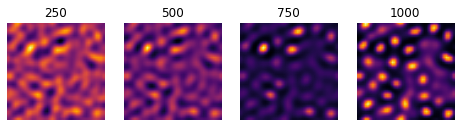

In [46]:
turing()

## Usage examples

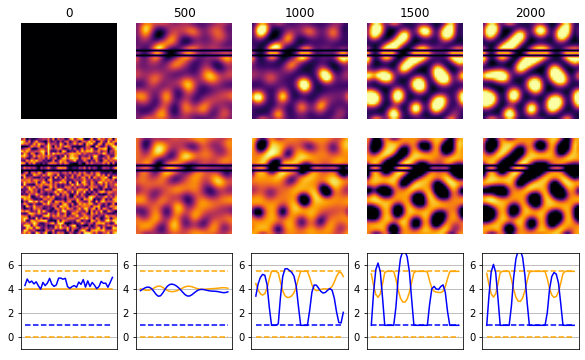

In [47]:
# show A, B and 1D detail view (dashed lines are the lower and upper bounds for concentrations)
# show initial state (iteration 0)
# enforce a lower bound for B and an upper bound for A
turing(show='ab', detail=12, extent=(-1,7), first=True, snap=5, stop=2000, scale=2, inf_b=1.0, sup_a=5.5)

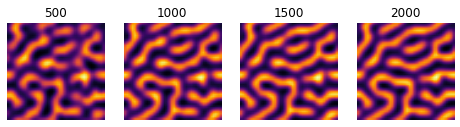

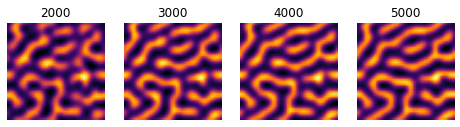

In [48]:
# set non-zero 'start' iteration count
# 'time' adjusts number of iterations accordingly to speed
turing(ratio=15, stop=2000)
turing(ratio=15, start=1000, time=2000, speed=50)

In [49]:
# skip output, but still stop at a stable pattern
turing(detect=True, info=True, ini_a=4, ini_b=4, var_b=2, stop=10000, show='')

A [2.67, 7.31] <2.67, 8.13>  B [0.00, 8.49] <0.00, 8.51>   stability of A at 8700


In [50]:
# stop prematurely when concentrations turn constant
turing(detect=True, ini_a=3, ini_b=4, var_b=0.1)
print('is uniform?', sim.is_uniform)

is uniform? True


In [51]:
# fields available for simulation object
for i in sorted(sim):
    print(i + '=' + repr(sim[i]))

axis=False
cmap='inferno'
delta_t=0.01
detail=None
detect=100
diff_a=5
diff_b=1
dpi=100
extent=(0, 10)
first=False
func=None
inf_a=0
inf_b=0
info=False
ini_a=3
ini_b=4
interpolation='bilinear'
is_nan=False
is_stable=False
is_uniform=True
iteration=200
limit=None
model=<function turing_model at 0x7fc1e07a3c20>
out=None
ratio=5
scale=1
seed=1
shape=(40, 40)
show='a'
size=2
snap=array([ 250,  500,  750, 1000])
speed=100
start=0
stop=1000
sup_a=1000
sup_b=1000
time=None
use_a=False
use_b=False
var_a=0
var_b=0.1
wrap=True
